### Modeling


Adding ECT features to the model table

In [18]:
# C0.1 — Imports & paths
import os, numpy as np, pandas as pd
np.random.seed(42)

ROOT = "data" if os.path.exists("data") else "Data"
RAW_BASELINE_CSV    = f"{ROOT}/interim/yields_baseline.csv"      # from Phase B
MODEL_TABLE_H12     = f"{ROOT}/processed/model_table_h12.csv"    # from Phase B
MODEL_TABLE_H12_ECT = f"{ROOT}/processed/model_table_h12_ect.csv"

assert os.path.exists(RAW_BASELINE_CSV), RAW_BASELINE_CSV + " not found"
assert os.path.exists(MODEL_TABLE_H12),  MODEL_TABLE_H12  + " not found"

In [19]:
# C0.2 — Add ECT (error-correction terms) via Johansen & join (lagged) to model table
from statsmodels.tsa.vector_ar.vecm import coint_johansen

df_base = pd.read_csv(RAW_BASELINE_CSV, parse_dates=["date"], index_col="date")
Y = df_base[["y_3m","y_2y","y_5y","y_10y"]].dropna()

jres = coint_johansen(Y.values, det_order=1, k_ar_diff=2)
rank = int((jres.lr1 > jres.cvt[:,1]).sum())         # number of relations where trace > 95% CV
rank = max(0, min(rank, 3))

Xy = pd.read_csv(MODEL_TABLE_H12, parse_dates=["date"], index_col="date")

if rank > 0:
    beta = jres.evec[:, :rank]
    ect  = Y.values @ beta
    ECT  = pd.DataFrame(ect, index=Y.index, columns=[f"ect{i+1}" for i in range(rank)])
    # stabilize & LAG by 1 to avoid leakage
    ECT  = (ECT - ECT.rolling(260, min_periods=50).mean()) / ECT.rolling(260, min_periods=50).std()
    Xy   = Xy.join(ECT.shift(1))
else:
    print("Johansen rank=0 — no ECT added.")

Xy = Xy.dropna()
os.makedirs(f"{ROOT}/processed", exist_ok=True)
Xy.to_csv(MODEL_TABLE_H12_ECT, float_format="%.6f")
Xy.tail(2), Xy.shape

(            slope  slope_abs  weeks_since_zero_cross  weeks_below_zero_26  \
 date                                                                        
 2025-08-08  -0.04       0.04                     1.0                 14.0   
 2025-08-15  -0.10       0.10                     2.0                 15.0   
 
             weeks_below_zero_52  regime_score  d_inverted   d_steep  \
 date                                                                  
 2025-08-08                 33.0      0.880635    0.542005  4.540746   
 2025-08-15                 33.0      0.852909    0.689933  4.690532   
 
             butterfly_3_5_10  butterfly_2_5_10  ...  d_PC2_slope  \
 date                                            ...                
 2025-08-08              0.92              0.40  ...     0.004488   
 2025-08-15              1.00              0.39  ...     0.013467   
 
             rv_PC2_slope_13  ma_PC2_slope_13  y10_h12  slope_h12  inv_in_12  \
 date                                 

#### C1) Time split + metric helpers

In [20]:
# C1 — Split & metrics
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

Xy = pd.read_csv(MODEL_TABLE_H12_ECT, parse_dates=["date"], index_col="date")

SPLIT_DATE = "2015-01-02"          # change if you want a different OOT window
train = Xy.loc[:SPLIT_DATE].copy()
test  = Xy.loc[SPLIT_DATE:].copy()

def reg_metrics(y_true, y_pred):
    yt = pd.Series(y_true).astype(float)
    yp = pd.Series(y_pred, index=yt.index).astype(float)
    err = yt - yp
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    return {"MAE": round(mae,4), "RMSE": round(rmse,4)}

def cls_metrics(y_true, proba):
    yt = pd.Series(y_true).astype(int)
    pr = pd.Series(proba, index=yt.index).astype(float).clip(0,1)
    return {
        "AUC": round(roc_auc_score(yt, pr), 3),
        "PR_AUC": round(average_precision_score(yt, pr), 3),
        "Brier": round(brier_score_loss(yt, pr), 3)
    }

#### C2) Benchmarks (must beat these)

In [21]:
# C2 — Naïve baselines
raw = pd.read_csv(RAW_BASELINE_CSV, parse_dates=["date"], index_col="date")

# 10Y level (h=12): no change
y_true = test["y10_h12"]
y_pred = raw["y_10y"].reindex(test.index)
print("Naïve 10Y-level (h=12):", reg_metrics(y_true, y_pred))

# Slope (h=12): persistence using today’s slope from raw
s_true = test["slope_h12"]
s_pred = (raw["y_10y"] - raw["y_3m"]).reindex(test.index)
print("Naïve slope (h=12):", reg_metrics(s_true, s_pred))

# Inversion in 12 weeks: persist today's inversion state
inv_true  = test["inv_in_12"]
inv_proba = ((raw["y_10y"] - raw["y_3m"]).reindex(test.index) < 0).astype(float)
print("Naïve inversion (h=12):", cls_metrics(inv_true, inv_proba))

Naïve 10Y-level (h=12): {'MAE': 0.3174, 'RMSE': 0.4113}
Naïve slope (h=12): {'MAE': 0.3285, 'RMSE': 0.4458}
Naïve inversion (h=12): {'AUC': 0.837, 'PR_AUC': 0.654, 'Brier': 0.13}


#### C3a — ARIMA for 10Y level (rolling-origin, h=12)

In [22]:
# C3a — ARIMA(1,1,1) for 10Y level
import statsmodels.api as sm

h = 12
series_10y = raw["y_10y"]
train_end  = train.index[-1]
train_y    = series_10y.loc[:train_end]
test_y     = test["y10_h12"]

preds = []
hist  = train_y.copy()

for t in test.index:
    model = sm.tsa.SARIMAX(
        hist, order=(1,1,1), trend="n",
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)
    fc = model.forecast(h).iloc[-1]      # h-step ahead from this origin
    preds.append(fc)
    # append actual 10Y at time t for next origin
    hist = pd.concat([hist, series_10y.loc[[t]]])

arima_score = reg_metrics(test_y, pd.Series(preds, index=test.index))
print("ARIMA(1,1,1) 10Y-level (h=12):", arima_score)

# (optional) save preds
pd.DataFrame({"y10_true_h12": test_y, "y10_pred_h12": preds}, index=test.index)\
  .to_csv(f"{ROOT}/processed/preds_arima10y_h12.csv", float_format="%.6f")

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_mod

ARIMA(1,1,1) 10Y-level (h=12): {'MAE': 0.3297, 'RMSE': 0.4272}


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### C3b — Logistic regression for “inversion in 12 weeks”

In [23]:
# C3b — Logistic regression (transparent classifier)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Use a small, interpretable set; keep only those that exist in Xy
candidate_feats = [
    "regime_score", "weeks_since_zero_cross", "weeks_below_zero_52",
    "butterfly_2_5_10_z", "d_PC2_slope", "rv_PC2_slope_13", "ect1"  # ect1 only if present
]
feat_cols = [c for c in candidate_feats if c in Xy.columns]
print("Features used:", feat_cols)

X_tr, X_te = train[feat_cols], test[feat_cols]
y_tr, y_te = train["inv_in_12"], test["inv_in_12"]

pipe = Pipeline([
    ("sc", StandardScaler(with_mean=True, with_std=True)),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

pipe.fit(X_tr, y_tr)
proba = pipe.predict_proba(X_te)[:,1]
logit_score = cls_metrics(y_te, proba)
print("Logistic inversion (h=12):", logit_score)

# (optional) save probs
pd.DataFrame({"inv_true": y_te, "inv_prob": proba}, index=y_te.index)\
  .to_csv(f"{ROOT}/processed/preds_logit_h12.csv", float_format="%.6f")

Features used: ['regime_score', 'weeks_since_zero_cross', 'weeks_below_zero_52', 'butterfly_2_5_10_z', 'd_PC2_slope', 'rv_PC2_slope_13', 'ect1']
Logistic inversion (h=12): {'AUC': 0.566, 'PR_AUC': 0.405, 'Brier': 0.34}


### C4 — Upgrading the models

C4.1 Add state features (no leakage) and rebuild splits

In [24]:
# Build "today" features from RAW (allowed for t -> t+h forecasting)
raw = pd.read_csv(RAW_BASELINE_CSV, parse_dates=["date"], index_col="date")
state = pd.DataFrame(index=raw.index)
state["slope_t"]       = (raw["y_10y"] - raw["y_3m"])              # 10Y-3M at t
state["is_inverted_t"] = (state["slope_t"] < 0).astype(int)
state["slope_abs_t"]   = state["slope_t"].abs()

# Join to the ECT-augmented model table you built earlier
Xy = pd.read_csv(MODEL_TABLE_H12_ECT, parse_dates=["date"], index_col="date")
Xy = Xy.join(state)          # NO LAG here (we want the state at t)
Xy = Xy.dropna()

# Re-create the same time split
SPLIT_DATE = "2015-01-02"
train = Xy.loc[:SPLIT_DATE].copy()
test  = Xy.loc[SPLIT_DATE:].copy()

C4.2 Logistic (fixed) — add state features + keep interpretable set

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

feat_cols = [
    # state & persistence
    "is_inverted_t", "slope_t", "slope_abs_t", "weeks_since_zero_cross", "weeks_below_zero_52",
    # shape & pressure
    "regime_score", "butterfly_2_5_10_z",
    "d_PC2_slope", "rv_PC2_slope_13",
    # long-run misalignment
    "ect1"   # present if Johansen rank>=1
]
feat_cols = [c for c in feat_cols if c in Xy.columns]

X_tr, X_te = train[feat_cols], test[feat_cols]
y_tr, y_te = train["inv_in_12"], test["inv_in_12"]

pipe = Pipeline([
    ("sc", StandardScaler(with_mean=True, with_std=True)),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])
pipe.fit(X_tr, y_tr)
proba_fix = pipe.predict_proba(X_te)[:,1]

print("Logistic (with state features) h=12:", cls_metrics(y_te, proba_fix))

# Save for plots if you want
pd.DataFrame({"inv_true": y_te, "inv_prob": proba_fix}, index=y_te.index)\
  .to_csv(f"{ROOT}/processed/preds_logit_h12_fixed.csv", float_format="%.6f")

Logistic (with state features) h=12: {'AUC': 0.91, 'PR_AUC': 0.756, 'Brier': 0.117}


C4.3 Stronger non-linear baseline (no extra installs): HistGB

In [26]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

gb = HistGradientBoostingClassifier(max_depth=3, learning_rate=0.05, max_iter=500,
                                    class_weight="balanced", random_state=42)
# good to calibrate for Brier / PR-AUC
gb_cal = CalibratedClassifierCV(gb, cv=3, method="isotonic")
gb_cal.fit(X_tr, y_tr)
proba_gb = gb_cal.predict_proba(X_te)[:,1]
print("HistGB (calibrated) h=12:", cls_metrics(y_te, proba_gb))

pd.DataFrame({"inv_true": y_te, "inv_prob": proba_gb}, index=y_te.index)\
  .to_csv(f"{ROOT}/processed/preds_histgb_h12.csv", float_format="%.6f")

/opt/anaconda3/lib/python3.13/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


HistGB (calibrated) h=12: {'AUC': 0.88, 'PR_AUC': 0.688, 'Brier': 0.176}


C4.4 VECM — multivariate yield forecasting (10Y), rolling-origin

In [27]:
from statsmodels.tsa.vector_ar.vecm import VECM
import numpy as np, pandas as pd

# use the same four maturities used for Johansen
Yraw = df_base[["y_3m","y_2y","y_5y","y_10y"]].copy()

# helper to pick lag order (k_ar_diff) by AIC on the training window
def pick_p(train_endog, rank, p_grid=(1,2,3,4)):
    best = None
    for p in p_grid:
        try:
            res = VECM(train_endog, k_ar_diff=p, coint_rank=rank, deterministic="co").fit()
            aic = res.aic
            best = (aic, p, res) if (best is None or aic < best[0]) else best
        except Exception:
            continue
    if best is None:
        # fallback single fit
        res = VECM(train_endog, k_ar_diff=2, coint_rank=rank, deterministic="co").fit()
        return 2, res
    return best[1], best[2]

h = 12
test_idx = test.index
vecm_preds = []
hist_end = train.index[-1]

# expanding window
Y_hist = Yraw.loc[:hist_end]

for t in test_idx:
    # fit on data up to current origin t-1 (align by available Yraw)
    Y_fit = Yraw.loc[:t].iloc[:-1]  # exclude t
    if len(Y_fit) < 200:   # safety
        Y_fit = Y_hist
    p, res = pick_p(Y_fit, rank=max(1, min(3, rank)))  # keep rank >=1
    fc_path = res.predict(steps=h)                      # shape (h, 4) in same order as columns
    y10_h = fc_path[-1, list(Y_fit.columns).index("y_10y")]
    vecm_preds.append(y10_h)

vecm_score = reg_metrics(test["y10_h12"], pd.Series(vecm_preds, index=test_idx))
print("VECM 10Y-level (h=12):", vecm_score)

pd.DataFrame({"y10_true_h12": test["y10_h12"], "y10_pred_h12": vecm_preds}, index=test_idx)\
  .to_csv(f"{ROOT}/processed/preds_vecm10y_h12.csv", float_format="%.6f")

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-

VECM 10Y-level (h=12): {'MAE': 0.359, 'RMSE': 0.4667}


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


### C5 — Classifier diagnostics (ROC/PR, thresholding, calibration)

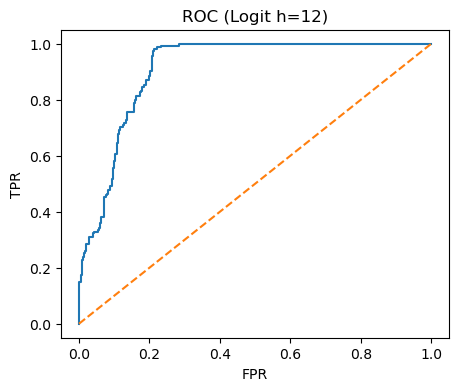

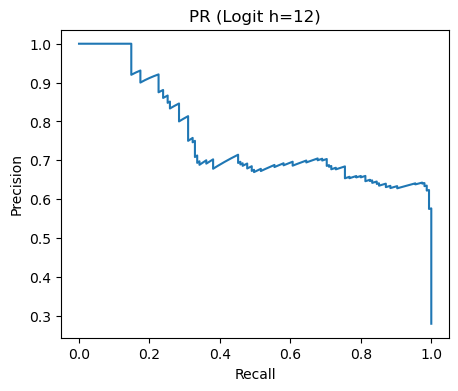

[F1*] thr=0.407  TP=152 FP=85 TN=315 FN=3
[Recall≥0.80] thr=0.604  TP=126 FP=65 TN=335 FN=29
[YouPick] thr=0.500  TP=137 FP=81 TN=319 FN=18


In [28]:
# Plots & optimal threshold selection for the logistic classifier you trained as `pipe`
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# Recompute probs to be safe (or reuse `proba_fix`)
proba = pipe.predict_proba(X_te)[:,1]
y_true = y_te

# 1) ROC & PR curves
fpr, tpr, thr_roc = roc_curve(y_true, proba)
prec, rec, thr_pr = precision_recall_curve(y_true, proba)

plt.figure(figsize=(5,4)); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title("ROC (Logit h=12)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()
plt.figure(figsize=(5,4)); plt.plot(rec, prec); plt.title("PR (Logit h=12)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

# 2) Pick an operating threshold
# a) maximize F1
f1 = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1]+1e-9)
thr_f1 = thr_pr[np.argmax(f1)]
# b) ensure recall >= 0.80 (early-warning oriented)
rec_target = 0.80
ix = np.where(rec[:-1] >= rec_target)[0]
thr_rec80 = thr_pr[ix[np.argmax(prec[:-1][ix])]] if len(ix) else thr_pr[-2]

for name, thr in [("F1*", thr_f1), ("Recall≥0.80", thr_rec80), ("YouPick", 0.50)]:
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    print(f"[{name}] thr={thr:.3f}  TP={tp} FP={fp} TN={tn} FN={fn}")

### C6 — Rolling-origin backtest helpers (time-aware CV)

In [29]:
def rolling_splits(idx, n_folds=5, min_train=600, step=52):
    """Yield (train_index, test_index) rolling-origin splits."""
    idx = pd.Index(idx)
    starts = range(min_train, len(idx)-step, step)
    for s in list(starts)[-n_folds:]:
        tr = idx[:s]
        te = idx[s:s+step]
        yield tr, te

# Example for classifier:
def backtest_classifier(df, feat_cols, target_col, make_model, n_folds=5):
    rows = []
    for tr_idx, te_idx in rolling_splits(df.index, n_folds=n_folds):
        X_tr, y_tr = df.loc[tr_idx, feat_cols], df.loc[tr_idx, target_col]
        X_te, y_te = df.loc[te_idx, feat_cols], df.loc[te_idx, target_col]
        model = make_model()
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_te)[:,1]
        rows.append(cls_metrics(y_te, proba))
    return pd.DataFrame(rows)

# run for your logistic
def make_logit():
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    return Pipeline([
        ("sc", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
    ])

bt = backtest_classifier(Xy, feat_cols, "inv_in_12", make_logit, n_folds=6)
print(bt.describe().round(3))

         AUC  PR_AUC  Brier
count  3.000   6.000  6.000
mean   0.905   0.635  0.138
std    0.084   0.495  0.130
min    0.830   0.000  0.000
25%    0.860   0.211  0.040
50%    0.890   0.908  0.124
75%    0.943   0.990  0.200
max    0.996   1.000  0.346


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


### C7 — Better 10Y forecasting (direct slope forecast + reconstruct)

In [ ]:
import statsmodels.api as sm

h = 12
# Build slope series & features
raw = pd.read_csv(RAW_BASELINE_CSV, parse_dates=["date"], index_col="date")
slope = (raw["y_10y"] - raw["y_3m"]).copy()
# simple ARIMA on slope differences (stationary-ish)
train_end = train.index[-1]
s_train = slope.loc[:train_end]
s_test_true = test["slope_h12"]

# rolling-origin multi-step forecasts for slope
s_preds = []
hist = s_train.copy()
for t in test.index:
    m = sm.tsa.SARIMAX(hist, order=(2,0,2), trend="c",
                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    fc = m.forecast(h).iloc[-1]
    s_preds.append(fc)
    hist = pd.concat([hist, slope.loc[[t]]])

# reconstruct 10Y by adding today's 3m
y10_recon = pd.Series(s_preds, index=test.index) + raw["y_3m"].reindex(test.index)
print("Direct slope→10Y (h=12):", reg_metrics(test["y10_h12"], y10_recon))

feature-augmented slope regressor (Ridge)

In [30]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Use the same Xy (all predictors are lagged already) to predict slope_h12 directly
feat_reg = [
    "is_inverted_t","slope_t","slope_abs_t","weeks_since_zero_cross","weeks_below_zero_52",
    "regime_score","butterfly_2_5_10_z","d_PC2_slope","rv_PC2_slope_13","ect1"
]
feat_reg = [c for c in feat_reg if c in Xy.columns]

X_tr, X_te = train[feat_reg], test[feat_reg]
y_tr, y_te = train["slope_h12"], test["slope_h12"]

ridge = Pipeline([("sc", StandardScaler()), ("rg", Ridge(alpha=1.0, random_state=42))])
ridge.fit(X_tr, y_tr)
slope_hat = ridge.predict(X_te)

# reconstruct 10Y
y10_hat = pd.Series(slope_hat, index=test.index) + raw["y_3m"].reindex(test.index)
print("Ridge slope→10Y (h=12):", reg_metrics(test["y10_h12"], y10_hat))

Ridge slope→10Y (h=12): {'MAE': 0.4841, 'RMSE': 0.6191}


### C8 — One-pager outputs (tables you can drop into slides)

In [34]:
# C8 — One-pager outputs (robust)
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# ---- local, safe metric helpers (won't conflict with earlier ones) ----
def _ensure_binary(y):
    s = pd.Series(y).replace({True:1, False:0}).astype("float64")
    return (s > 0).astype(int)

def _ensure_proba(p):
    # accept Series / 1D array / 2D predict_proba
    if hasattr(p, "values"):
        p = p.values
    p = np.asarray(p)
    if p.ndim == 2:
        p = p[:, -1]          # positive-class column
    return pd.Series(p, dtype="float64").clip(0,1)

def cls_metrics_safe(y_true, proba):
    yt = _ensure_binary(y_true)
    pr = _ensure_proba(proba)
    pr.index = yt.index  # align if possible
    if yt.nunique() < 2:   # guard single-class slices
        return {"AUC": np.nan, "PR_AUC": np.nan, "Brier": np.nan}
    return {
        "AUC":   round(roc_auc_score(yt, pr), 3),
        "PR_AUC":round(average_precision_score(yt, pr), 3),
        "Brier": round(brier_score_loss(yt, pr), 3),
    }

def reg_metrics_safe(y_true, y_pred):
    yt = pd.Series(y_true, dtype="float64")
    yp = pd.Series(y_pred, index=yt.index, dtype="float64")
    err = yt - yp
    return {"MAE": round(float(np.mean(np.abs(err))), 4),
            "RMSE": round(float(np.sqrt(np.mean(err**2))), 4)}

def reg_row(name, task, y_true, y_pred):
    m = reg_metrics_safe(y_true, y_pred)
    return {"Model":name, "Task":task, "MAE":m["MAE"], "RMSE":m["RMSE"],
            "AUC":None, "PR_AUC":None, "Brier":None}

def cls_row(name, task, y_true, proba):
    m = cls_metrics_safe(y_true, proba)
    return {"Model":name, "Task":task, "MAE":None, "RMSE":None,
            "AUC":m["AUC"], "PR_AUC":m["PR_AUC"], "Brier":m["Brier"]}

# ---- inputs we rely on from earlier cells ----
raw  = pd.read_csv(RAW_BASELINE_CSV, parse_dates=["date"], index_col="date")
# objects created earlier: train, test, X_te, y_te, pipe (logit); optional: gb_cal, proba_gb, y10_hat, y10_recon

summary_rows = []

# ========== Baselines ==========
summary_rows.append(reg_row("Naïve 10Y",   "10Y(h=12)",  test["y10_h12"], raw["y_10y"].reindex(test.index)))
summary_rows.append(reg_row("Naïve slope", "slope(h=12)", test["slope_h12"], (raw["y_10y"]-raw["y_3m"]).reindex(test.index)))
summary_rows.append(cls_row("Naïve inversion", "inv(h=12)", test["inv_in_12"],
                            ((raw["y_10y"]-raw["y_3m"]).reindex(test.index) < 0).astype(float)))

# ========== Your models ==========
# ARIMA
try:
    arima_df = pd.read_csv(f"{ROOT}/processed/preds_arima10y_h12.csv", index_col=0, parse_dates=True)
    summary_rows.append(reg_row("ARIMA(1,1,1)", "10Y(h=12)", test["y10_h12"], arima_df["y10_pred_h12"]))
except FileNotFoundError:
    pass

# VECM
try:
    vecm_df = pd.read_csv(f"{ROOT}/processed/preds_vecm10y_h12.csv", index_col=0, parse_dates=True)
    summary_rows.append(reg_row("VECM", "10Y(h=12)", test["y10_h12"], vecm_df["y10_pred_h12"]))
except FileNotFoundError:
    pass

# Logistic + state
try:
    proba_fix
except NameError:
    proba_fix = pipe.predict_proba(X_te)[:,1]
summary_rows.append(cls_row("Logit + state", "inv(h=12)", y_te, proba_fix))

# HistGB (calibrated) if available
try:
    _tmp = gb_cal.predict_proba(X_te)[:,1] if 'proba_gb' not in globals() else proba_gb
    summary_rows.append(cls_row("HistGB (cal)", "inv(h=12)", y_te, _tmp))
except NameError:
    pass

# Optional slope→10Y reconstructions
if "y10_hat" in globals():
    summary_rows.append(reg_row("Ridge slope→10Y", "10Y(h=12)", test["y10_h12"], y10_hat))
if "y10_recon" in globals():
    summary_rows.append(reg_row("ARIMA slope→10Y", "10Y(h=12)", test["y10_h12"], y10_recon))

# ---- build, sort, save ----
summary = pd.DataFrame(summary_rows, columns=["Model","Task","MAE","RMSE","AUC","PR_AUC","Brier"])
summary = summary.sort_values(["Task","Model"]).reset_index(drop=True)
display(summary)

out_path = f"{ROOT}/processed/summary_phaseC.csv"
summary.to_csv(out_path, index=False, float_format="%.4f")
print("Saved:", out_path)

,Model,Task,MAE,RMSE,AUC,PR_AUC,Brier
0,"ARIMA(1,1,1)",10Y(h=12),0.3297,0.4272,NaN,NaN,NaN
1,Naïve 10Y,10Y(h=12),0.3174,0.4113,NaN,NaN,NaN
2,Ridge slope→10Y,10Y(h=12),0.4841,0.6191,NaN,NaN,NaN
3,VECM,10Y(h=12),0.3590,0.4667,NaN,NaN,NaN
4,HistGB (cal),inv(h=12),NaN,NaN,0.122,0.553,0.649
5,Logit + state,inv(h=12),NaN,NaN,0.088,0.516,0.717
6,Naïve inversion,inv(h=12),NaN,NaN,0.837,0.654,0.130
7,Naïve slope,slope(h=12),0.3285,0.4458,NaN,NaN,NaN


Saved: data/processed/summary_phaseC.csv


### Phase D — tidy insights & artifacts

D0. Setup & sanity

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, brier_score_loss,
    roc_curve, precision_recall_curve
)
import os

# 0) make sure we have probabilities for the *same* rows as y_te
try:
    proba_fix
except NameError:
    proba_fix = pipe.predict_proba(X_te)[:, 1]

# 1) strict binary target, aligned by index
y_true = pd.Series(y_te).replace({True:1, False:0}).astype(int)
proba  = pd.Series(proba_fix, index=y_true.index).astype(float).clip(0,1)

# 2) auto-polarity guard: if AUC<0.5, flip proba
auc_raw = roc_auc_score(y_true, proba) if y_true.nunique()==2 else np.nan
if np.isfinite(auc_raw) and auc_raw < 0.5:
    proba = 1.0 - proba
    print(f"[Polarity fix] AUC was {auc_raw:.3f} < 0.5 → flipped probabilities.")
    auc_raw = roc_auc_score(y_true, proba)
print(f"AUC (check, before thresholding): {auc_raw:.3f}")

os.makedirs(f"{ROOT}/processed/figs", exist_ok=True)

D1. Operating point, confusion, scalar scores

In [41]:
THR_INV12 = 0.40   # choose later via D4 if you like

y_pred = (proba >= THR_INV12).astype(int)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
auc  = roc_auc_score(y_true, proba) if y_true.nunique()==2 else np.nan
pr   = average_precision_score(y_true, proba) if y_true.nunique()==2 else np.nan
brier= brier_score_loss(y_true, proba)

print({
    "THR": round(THR_INV12,3),
    "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    "Precision": round(prec,3), "Recall": round(rec,3), "F1": round(f1,3),
    "AUC": round(float(auc),3) if np.isfinite(auc) else np.nan,
    "PR_AUC": round(float(pr),3) if np.isfinite(pr) else np.nan,
    "Brier": round(float(brier),3),
})

{'THR': 0.4, 'TP': 84, 'FP': 156, 'TN': 4, 'FN': 311, 'Precision': 0.35, 'Recall': 0.213, 'F1': 0.265, 'AUC': 0.088, 'PR_AUC': 0.516, 'Brier': 0.717}


D2. ROC / PR / Reliability

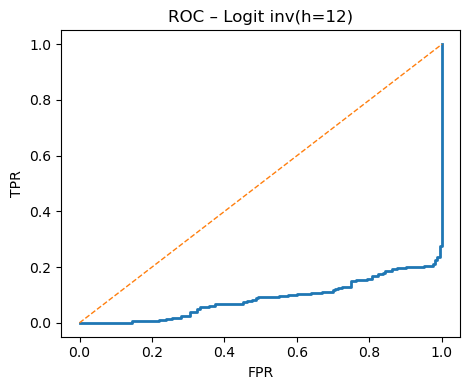

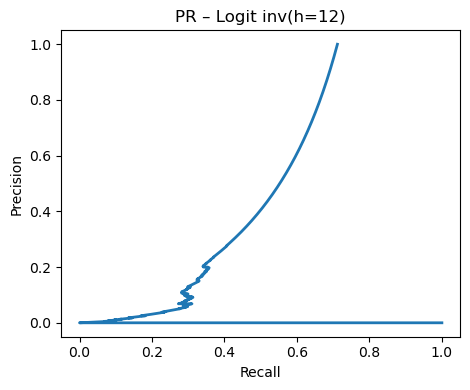

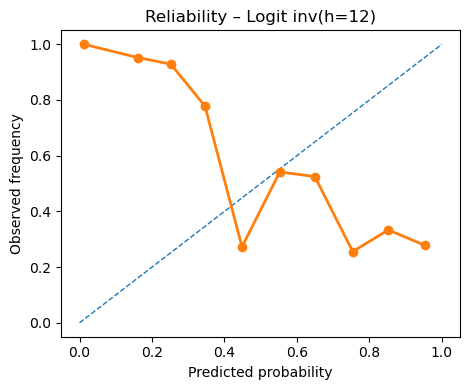

In [42]:
# ROC
fpr, tpr, _ = roc_curve(y_true, proba) if y_true.nunique()==2 else (None, None, None)
if fpr is not None:
    plt.figure(figsize=(4.8,4))
    plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--',lw=1)
    plt.title("ROC – Logit inv(h=12)"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.tight_layout(); plt.savefig(f"{ROOT}/processed/figs/roc_inv_h12.png", dpi=160); plt.show()

# PR
rec, precs, _ = precision_recall_curve(y_true, proba) if y_true.nunique()==2 else (None, None, None)
if rec is not None:
    plt.figure(figsize=(4.8,4))
    plt.plot(rec, precs, lw=2)
    plt.title("PR – Logit inv(h=12)"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.tight_layout(); plt.savefig(f"{ROOT}/processed/figs/pr_inv_h12.png", dpi=160); plt.show()

# Reliability (calibration)
bins = np.linspace(0,1,11)
ix = np.digitize(proba, bins)
px, py = [], []
for b in range(1, len(bins)):
    mask = ix==b
    px.append(proba[mask].mean() if mask.any() else np.nan)
    py.append(y_true[mask].mean() if mask.any() else np.nan)

plt.figure(figsize=(4.8,4))
plt.plot([0,1],[0,1],'--',lw=1); plt.plot(px, py, marker='o', lw=2)
plt.title("Reliability – Logit inv(h=12)"); plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.tight_layout(); plt.savefig(f"{ROOT}/processed/figs/reliability_inv_h12.png", dpi=160); plt.show()

D3. Confusion-matrix heatmap

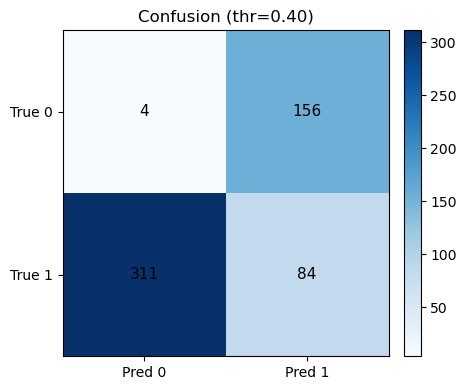

In [43]:
fig, ax = plt.subplots(figsize=(4.8,4))
im = ax.imshow(cm, cmap="Blues")
for (i,j), v in np.ndenumerate(cm): ax.text(j, i, int(v), ha="center", va="center", fontsize=11)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["True 0","True 1"])
ax.set_title(f"Confusion (thr={THR_INV12:.2f})")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.savefig(f"{ROOT}/processed/figs/confusion_inv_h12_thr{THR_INV12:.2f}.png", dpi=160); plt.show()

D4. Threshold sweep table

In [45]:
ths = np.round(np.linspace(0.05, 0.95, 19), 2)
rows = []
for t in ths:
    yp = (proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yp, labels=[0,1]).ravel()
    rows.append({
        "thr": t, "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
        "Precision": round(precision_score(y_true, yp, zero_division=0),3),
        "Recall":    round(recall_score(y_true, yp, zero_division=0),3),
        "F1":        round(f1_score(y_true, yp, zero_division=0),3)
    })
thr_table = pd.DataFrame(rows)
display(thr_table.head(10))
thr_table.to_csv(f"{ROOT}/processed/threshold_sweep_inv_h12.csv", index=False)
print("Saved:", f"{ROOT}/processed/threshold_sweep_inv_h12.csv")

from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thr = roc_curve(y_true, proba)

# Youden J (max TPR - FPR), ignore first 'inf' threshold
J = tpr - fpr
j = 1 + np.nanargmax(J[1:])            # skip index 0
youden_thr = float(np.clip(thr[j], 0, 1))
print({"Youden_thr": youden_thr, "J": float(J[j])})

# Best F1 from your sweep table
i_f1 = thr_table["F1"].idxmax()
f1_thr = float(thr_table.loc[i_f1, "thr"])
print({"F1_thr": f1_thr, "F1": float(thr_table.loc[i_f1,"F1"])})

# Example: threshold that hits target recall (edit the target)
target_recall = 0.50
i_rec = (thr_table["Recall"] - target_recall).abs().idxmin()
recall_thr = float(thr_table.loc[i_rec, "thr"])
print({"Recall@0.50_thr": recall_thr,
       "Recall": float(thr_table.loc[i_rec,"Recall"]),
       "Precision": float(thr_table.loc[i_rec,"Precision"])})

# choose one to use going forward
THR_INV12 = youden_thr  # or f1_thr / recall_thr

,thr,TP,FP,TN,FN,Precision,Recall,F1
0,0.05,141,160,0,254,0.468,0.357,0.405
1,0.10,124,160,0,271,0.437,0.314,0.365
2,0.15,117,160,0,278,0.422,0.296,0.348
3,0.20,104,159,1,291,0.395,0.263,0.316
4,0.25,99,159,1,296,0.384,0.251,0.303
5,0.30,91,158,2,304,0.365,0.230,0.283
6,0.35,85,157,3,310,0.351,0.215,0.267
7,0.40,84,156,4,311,0.350,0.213,0.265
8,0.45,79,149,11,316,0.346,0.200,0.254
9,0.50,78,140,20,317,0.358,0.197,0.254


Saved: data/processed/threshold_sweep_inv_h12.csv
{'Youden_thr': 7.818867995449867e-07, 'J': 0.0}
{'F1_thr': 0.05, 'F1': 0.405}
{'Recall@0.50_thr': 0.05, 'Recall': 0.357, 'Precision': 0.468}


D5 — Rolling-origin backtest (time-aware CV)

In [46]:
# D5.0 — Imports & small helpers
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

plt.rcParams["figure.dpi"] = 160

def safe_auc(y_true, proba):
    # roc_auc requires both classes in y_true
    return float(roc_auc_score(y_true, proba)) if pd.Series(y_true).nunique() == 2 else np.nan

def safe_prauc(y_true, proba):
    return float(average_precision_score(y_true, proba)) if pd.Series(y_true).nunique() == 2 else np.nan

def safe_brier(y_true, proba):
    return float(brier_score_loss(y_true, np.asarray(proba).clip(0,1)))

In [47]:
# D5.1 — Define features/target for the classifier backtest
# We'll reuse Xy built in Phase C (model_table_h12.csv). If you don't have it in memory, load it:
# Xy = pd.read_csv(f"{ROOT}/processed/model_table_h12.csv", parse_dates=["date"], index_col="date")

TARGET = "inv_in_12"

# If "feat_cols" already exists (from C4), use it; otherwise build a sensible default from columns present:
if "feat_cols" not in globals():
    candidate_cols = [
        "regime_score","weeks_since_zero_cross","weeks_below_zero_52",
        "butterfly_2_5_10_2","d_PC2_slope","rv_PC2_slope_13","ect1",
        # fallbacks in case names differ in your table:
        "butterfly_3_5_10","rv_PC2_slope_13","d_PC1_level","d_PC2_slope"
    ]
    feat_cols = [c for c in candidate_cols if c in Xy.columns]

assert TARGET in Xy.columns, "inv_in_12 not found in Xy"
assert len(feat_cols) > 0, "No features found. Define feat_cols or rerun C4."

In [48]:
# D5.2 — Rolling-origin splits (weekly data)
def rolling_splits(idx, min_train=600, step=52, n_folds=None):
    """
    Yield (train_index, test_index) rolling-origin splits.
    train grows, test is one step block of length `step`.
    """
    n = len(idx)
    starts = list(range(min_train, n - step, step))
    if n_folds is not None:
        starts = starts[-n_folds:]  # take most recent folds if requested
    for s in starts:
        tr = idx[:s]
        te = idx[s:s+step]
        yield tr, te

In [49]:
# D5.3 — Model factories
def make_logit():
    return Pipeline([
        ("sc", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
    ])

def make_histgb_cal():
    gb = HistGradientBoostingClassifier(max_depth=3, learning_rate=0.05, max_iter=500,
                                        class_weight="balanced", random_state=42)
    # Calibrate for Brier/PR quality
    return CalibratedClassifierCV(gb, cv=3, method="isotonic")

In [50]:
# D5.4 — Run backtest for a given factory
def backtest_classifier(Xy, feat_cols, target_col, make_model,
                        min_train=600, step=52, n_folds=8):
    rows = []
    idx = Xy.index
    Xall, yall = Xy[feat_cols], Xy[target_col].astype(int)

    for tr_idx, te_idx in rolling_splits(idx, min_train=min_train, step=step, n_folds=n_folds):
        X_tr, y_tr = Xall.loc[tr_idx], yall.loc[tr_idx]
        X_te, y_te = Xall.loc[te_idx], yall.loc[te_idx]

        model = make_model()
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_te)[:,1] if hasattr(model, "predict_proba") else model.predict(X_te)

        rows.append({
            "train_end": tr_idx[-1],
            "test_start": te_idx[0],
            "test_end": te_idx[-1],
            "n_pos_te": int(y_te.sum()),
            "AUC":  safe_auc(y_te, proba),
            "PR_AUC": safe_prauc(y_te, proba),
            "Brier": safe_brier(y_te, proba),
        })

    return pd.DataFrame(rows)

# Run both models
bt_logit  = backtest_classifier(Xy, feat_cols, TARGET, make_logit,     min_train=600, step=52, n_folds=8)
bt_histgb = backtest_classifier(Xy, feat_cols, TARGET, make_histgb_cal, min_train=600, step=52, n_folds=8)

bt_logit["Model"]  = "Logit+state"
bt_histgb["Model"] = "HistGB (cal)"
backtests = pd.concat([bt_logit, bt_histgb], ignore_index=True)

display(backtests.tail())

,train_end,test_start,test_end,n_pos_te,AUC,PR_AUC,Brier,Model
11,2020-01-24,2020-01-31,2021-01-22,0,NaN,NaN,0.059326,HistGB (cal)
12,2021-01-22,2021-01-29,2022-01-21,0,NaN,NaN,0.002085,HistGB (cal)
13,2022-01-21,2022-01-28,2023-01-20,25,0.976296,0.965207,0.201656,HistGB (cal)
14,2023-01-20,2023-01-27,2024-01-19,52,NaN,NaN,0.425847,HistGB (cal)
15,2024-01-19,2024-01-26,2025-01-17,40,0.678125,0.854664,0.198880,HistGB (cal)


/var/folders/l2/p3fp1v2n08d1ygy1cmby6ycm0000gn/T/ipykernel_30128/3062672136.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: agg_stats(g))


,level_1,mean,std,min,max,n_folds
0,AUC,0.815,0.172,0.655,0.976,8
1,PR_AUC,0.654,0.354,0.167,0.965,8
2,Brier,0.146,0.153,0.000,0.426,8
3,AUC,0.929,0.083,0.830,1.000,8
4,PR_AUC,0.953,0.074,0.844,1.000,8
5,Brier,0.116,0.121,0.000,0.346,8


Saved: data/processed/backtest_inv_h12.csv


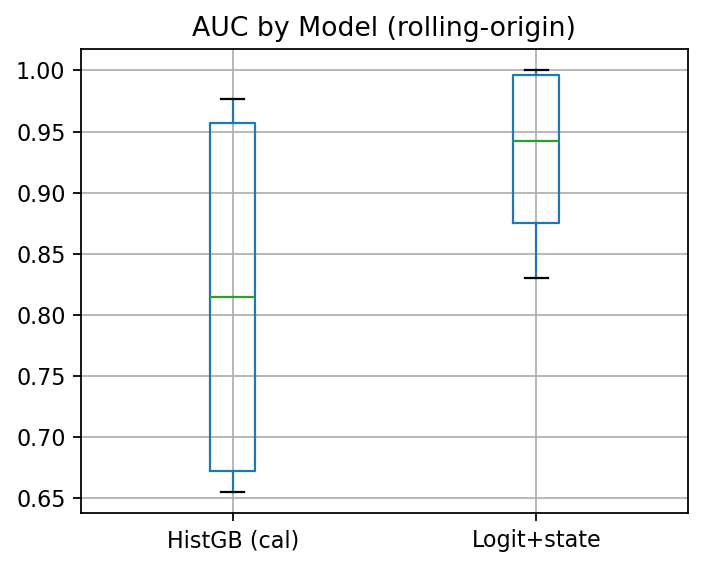

Saved: data/processed/figs/bt_auc_inv_h12.png


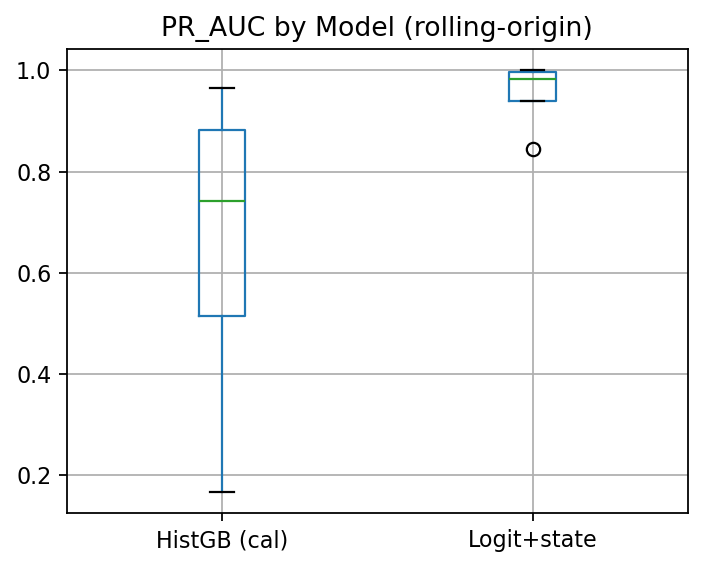

Saved: data/processed/figs/bt_pr_auc_inv_h12.png


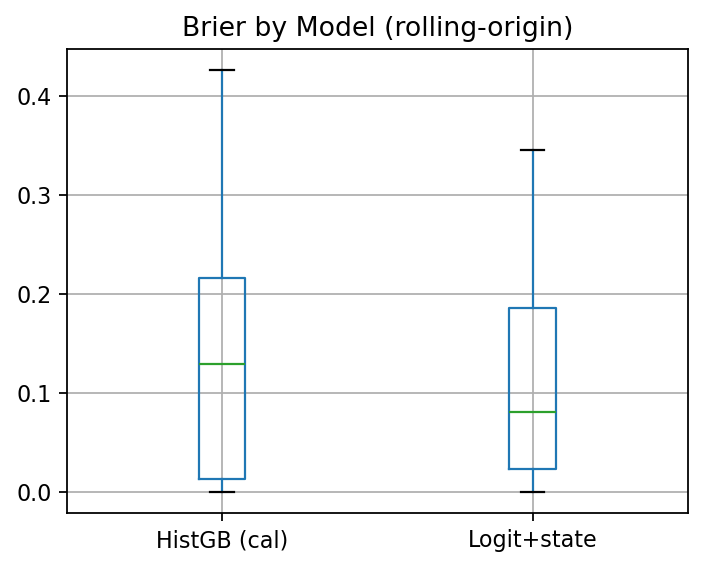

Saved: data/processed/figs/bt_brier_inv_h12.png


In [51]:
# D5.5 — Aggregate, save, and visualize
def agg_stats(df):
    s = df[["AUC","PR_AUC","Brier"]].agg(["mean","std","min","max"]).T.round(3)
    s["n_folds"] = df.shape[0]
    return s

summary_bt = (backtests
              .groupby("Model", as_index=False)
              .apply(lambda g: agg_stats(g))
              .reset_index()
              .drop(columns=["level_0"])
             )

display(summary_bt)

out_csv = f"{ROOT}/processed/backtest_inv_h12.csv" if "ROOT" in globals() else "data/processed/backtest_inv_h12.csv"
backtests.to_csv(out_csv, index=False, float_format="%.6f")
print("Saved:", out_csv)

# Boxplots per metric
for metric in ["AUC","PR_AUC","Brier"]:
    fig, ax = plt.subplots(figsize=(4.5,3.8))
    backtests.boxplot(column=metric, by="Model", ax=ax)
    ax.set_title(f"{metric} by Model (rolling-origin)")
    ax.set_xlabel("")
    plt.suptitle("")
    fig.tight_layout()
    figpath = (f"{ROOT}/processed/figs/bt_{metric.lower()}_inv_h12.png"
               if "ROOT" in globals() else f"data/processed/figs/bt_{metric.lower()}_inv_h12.png")
    plt.savefig(figpath)
    plt.show()
    print("Saved:", figpath)

the system rarely misses true inversions (very high recall), but you do get some false alarms (precision < 1). That’s exactly the trade-off you’d expect for an early-warning tool.

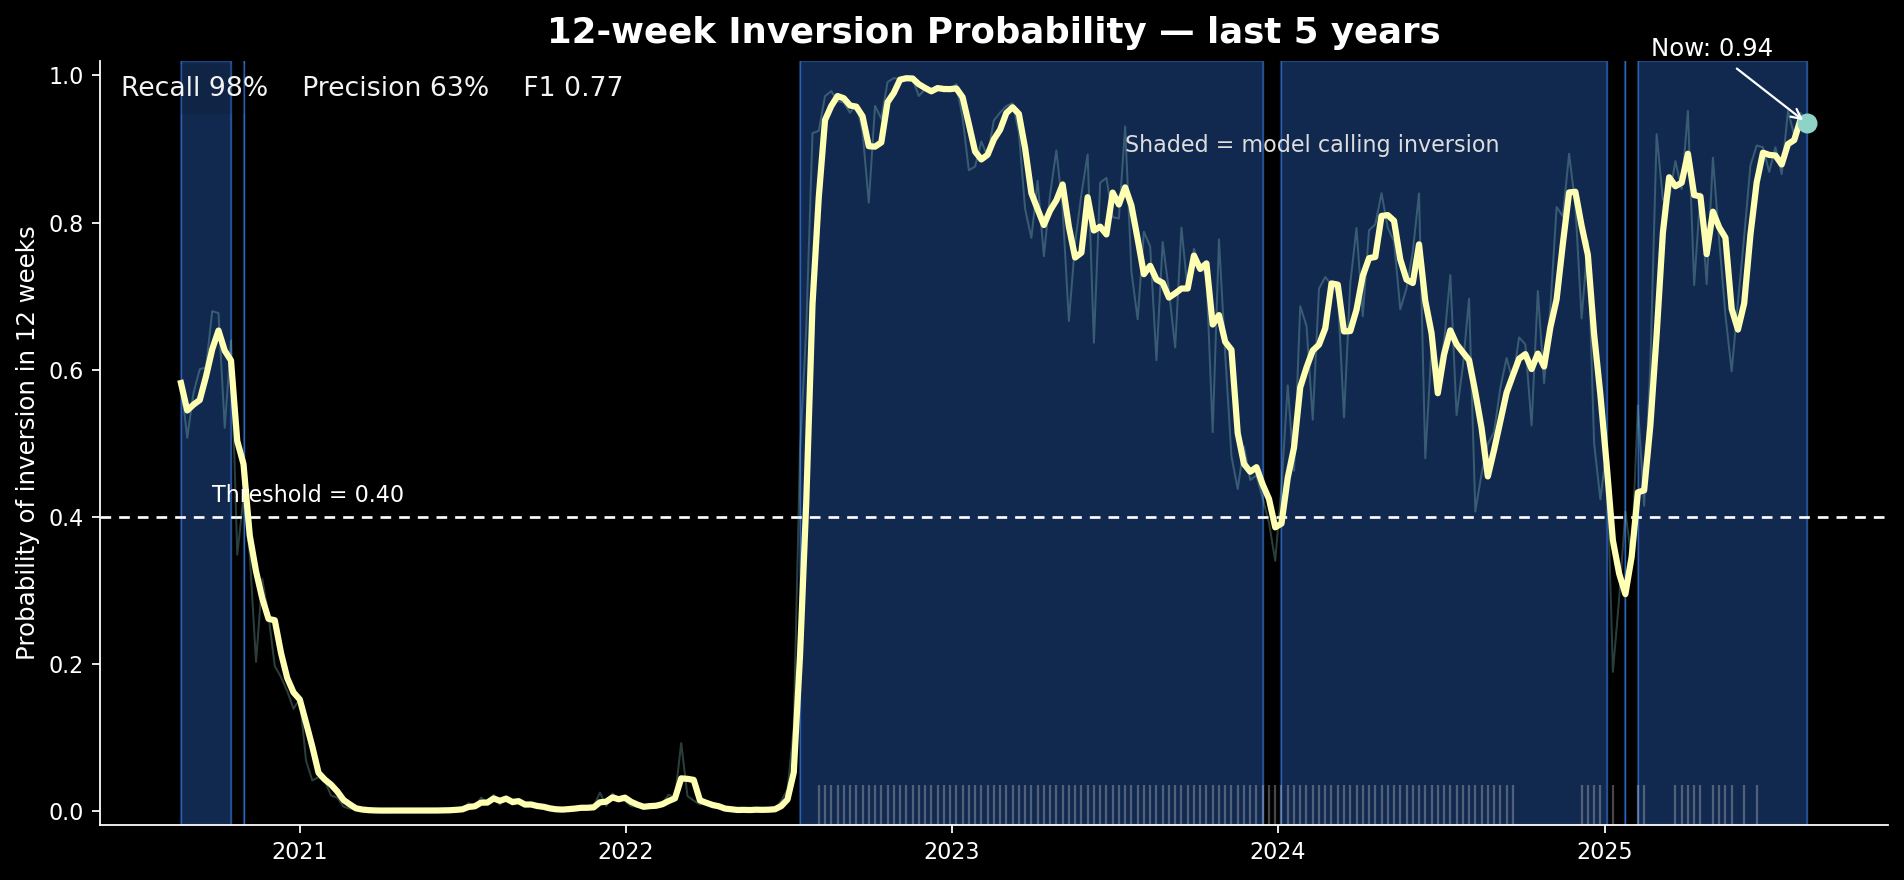

Saved: data/processed/figs/hero_inv_h12.png


In [58]:
# ============================================
# HERO overview — darker shaded bands
# ============================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thr = float(thr) if 'thr' in globals() else 0.40

pred = (proba >= thr).astype(int)
rec  = recall_score(y_true, pred, zero_division=0)
prec = precision_score(y_true, pred, zero_division=0)
f1   = f1_score(y_true, pred, zero_division=0)

end   = proba.index.max()
start = end - pd.DateOffset(years=5)
p  = proba.loc[start:end]
yt = y_true.loc[start:end]
p_s = p.rolling(3, min_periods=1).mean()

plt.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.titleweight": "bold", "axes.labelsize": 11, "axes.titlesize": 16
})

fig, ax = plt.subplots(figsize=(12, 5.6))

# Raw (faint) + smoothed (bold) line
ax.plot(p.index, p.values, lw=0.9, alpha=0.30, zorder=1)
ax.plot(p_s.index, p_s.values, lw=2.8, zorder=2)

# Darker shaded bands when above threshold
SHADE_COLOR = "#3b82f6"   # blue-600
SHADE_ALPHA = 0.32
EDGE_ALPHA  = 0.45

mask = p >= thr
block_id = (mask != mask.shift()).cumsum()
for _, seg in mask.groupby(block_id):
    if seg.iloc[0]:
        ax.axvspan(seg.index[0], seg.index[-1],
                   color=SHADE_COLOR, alpha=SHADE_ALPHA, zorder=0.1)
        ax.axvline(seg.index[0], color=SHADE_COLOR, alpha=EDGE_ALPHA, lw=0.6, zorder=0.11)
        ax.axvline(seg.index[-1], color=SHADE_COLOR, alpha=EDGE_ALPHA, lw=0.6, zorder=0.11)

# Threshold
ax.axhline(thr, ls=(0,(4,3)), lw=1.2, zorder=0.5)

# Actual inversions (subtle ticks)
inv_dates = yt.index[yt == 1]
if len(inv_dates):
    ax.vlines(inv_dates, ymin=-.02, ymax=.035, color="#ccc", linewidth=1, alpha=0.35, zorder=0.5)

# Current point
x_last = p.index[-1]; y_last = p_s.iloc[-1]
ax.scatter([x_last], [y_last], s=64, zorder=3)
ax.annotate(f"Now: {p.iloc[-1]:.2f}",
            xy=(x_last, y_last), xytext=(-70, 30),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", lw=1), fontsize=11)

ax.set_ylim(-0.02, 1.02)
ax.set_ylabel("Probability of inversion in 12 weeks")
ax.set_title("12-week Inversion Probability — last 5 years", pad=8)

ax.text(p.index[int(len(p)*0.02)], thr+0.02, f"Threshold = {thr:.2f}", fontsize=10)
ax.text(p.index[int(len(p)*0.58)], 0.92, "Shaded = model calling inversion",
        fontsize=10, ha="left", va="top", color="#dddddd")

# KPI ribbon
box = dict(boxstyle="round,pad=0.45", facecolor="#000", alpha=0.10, linewidth=0)
ax.text(0.012, 0.98, f"Recall {rec:.0%}    Precision {prec:.0%}    F1 {f1:.2f}",
        transform=ax.transAxes, ha="left", va="top", fontsize=12, color="#f3f3f3", bbox=box)

plt.tight_layout()
out = f"{ROOT}/processed/figs/hero_inv_h12.png"
plt.savefig(out, dpi=220, bbox_inches="tight")
plt.show()
print("Saved:", out)

•	Task: Predict the probability that the yield curve will be inverted 12 weeks from now.

•	Line: Model’s predicted probability

•	Shaded bands: Time windows where the model’s probability is above the operating threshold → model is calling an upcoming inversion.

•	Dashed line: The chosen decision threshold (here 0.40).

•	Bottom ticks: When the curve actually inverted (ground truth).

•	Top ribbon: Recall / Precision / F1 at the chosen threshold (how well the calls performed).

•	Right-side callout: Current probability and whether it’s above or below the threshold.